In [1]:

import pandas as pd
import dotenv
import os
from src.regime.utils import (
    retest_from_latest_base_swing,
    find_all_retest_swing,
    add_peak_regime_data,
)
from scripts.trend_viewer import *
dotenv.load_dotenv()

True

Control Panel

In [42]:
# Pull price data from db for this ticker
symbol = 'XLE'
interval = '1d'

In [43]:
# with pandas, select * from enhanced_price_table from NEONDB where symbol = symbol
neon_db_url = os.environ.get("NEON_DB_CONSTR")
# create query select left join where stock_data.stock_id equals select stock_id from stock where symbol = symbol

In [44]:
stock_data, regime_data, peak_data = get_stock_data(symbol, interval, neon_db_url)
stock_data.index = stock_data.bar_number
stock_data.index.name = 'index'

In [45]:
peak_data.lvl = peak_data.lvl.astype(int)
absolute_stock_data = add_peak_regime_data(
    stock_data.loc[stock_data.is_relative == False],
    regime_data.loc[regime_data.is_relative == False],
    peak_data.loc[peak_data.is_relative == False]
)

In [46]:
relative_stock_data = add_peak_regime_data(
    stock_data.loc[stock_data.is_relative == True],
    regime_data.loc[regime_data.is_relative == True],
    peak_data.loc[peak_data.is_relative == True]
)

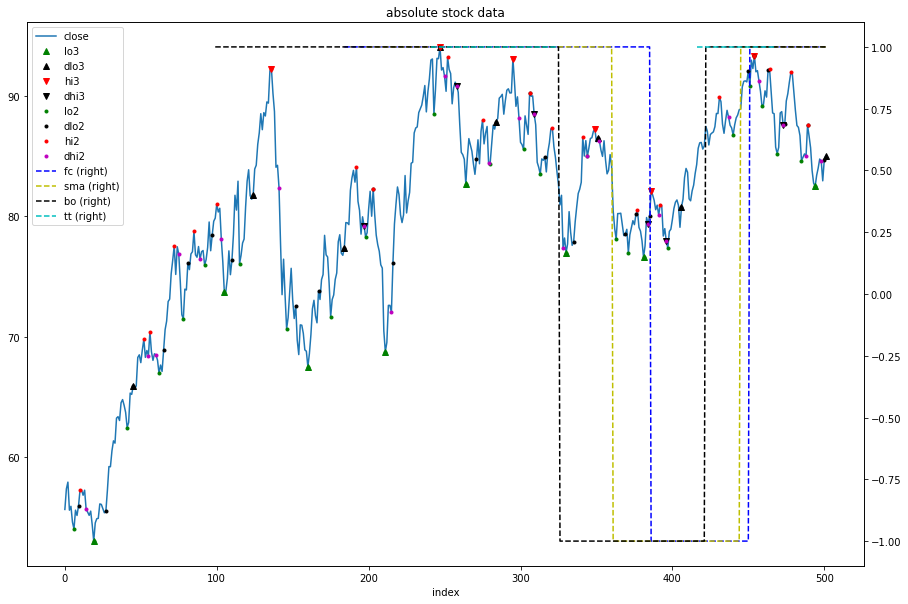

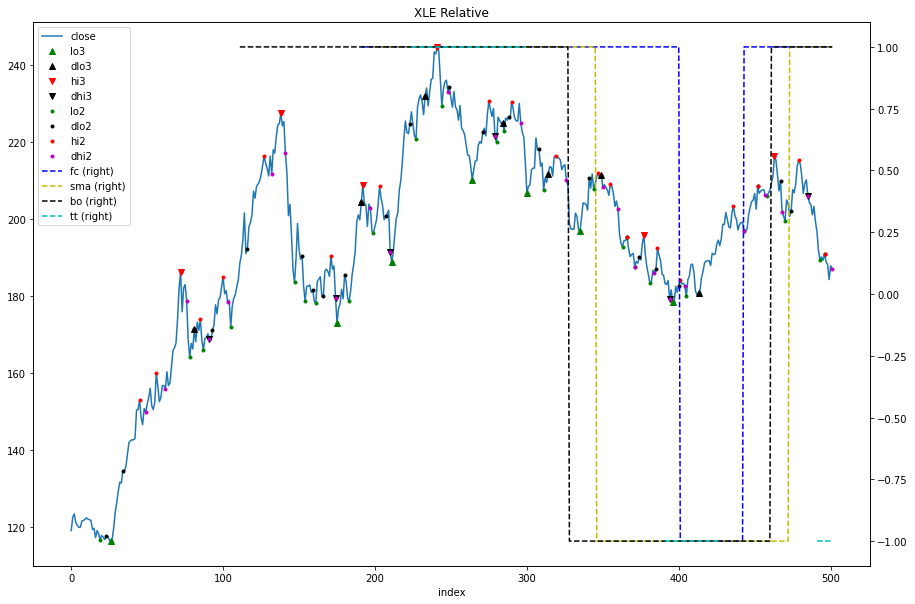

In [47]:
plot(absolute_stock_data, 'absolute stock data')
plot(relative_stock_data, f'{symbol} Relative')

In [48]:
import matplotlib.pyplot as plt
"""
calculate order data
- inputs: peak_row
- order_type (short/long) = peak_row['type']
- stop_loss = peak_row.st_px
- limit_price * order_type <= (peak_row.st_px * order_type) * 1.5 + (order_type *

target_price = en_px + ((en_px - stop_loss) * 1.5)
limit_entry <= (stop_loss * order_type) / (order_type - 0.02)
max_target_price = limit_entry + (limit_entry - stop_loss) * 1.5
if max_target_price < local_max, solve for limit_entry
limit_entry = (max_target_price - (stop_loss * order_type) * 1.5) / (order_type - 0.02)
"""
def entry_data_on_peak(_peak_data, entry_price, return_type):
    entry_data = return_type()
    entry_data['type'] = _peak_data['type']
    entry_data['stop_loss'] = _peak_data['st_px']
    entry_data['limit_entry'] = (entry_data["stop_loss"] * entry_data['type']) / (entry_data['type'] - 0.02)
    entry_data['limit_target_exit'] = entry_data["limit_entry"] + ((entry_data["limit_entry"] - entry_data["stop_loss"]) * .5)
    entry_data['peak_id'] = _peak_data.index
    return entry_data


def latest_entry_data_on_peak(_peak_table, entry_type, swing_lvl, return_type):
    filtered_peaks = _peak_table.loc[(_peak_table.lvl == swing_lvl) & (_peak_table['type'] == entry_type)]
    # sort by start
    selected_peak = filtered_peaks.sort_values(by=['start']).iloc[-1]

    return entry_data_on_peak(filtered_peaks.iloc[-1], return_type)

rel = True
entry_data = relative_stock_data

rel_filtered_regime_data = regime_data.loc[(regime_data.is_relative == True) & (regime_data.type == 'fc')]
abs_filtered_regime_data = regime_data.loc[(regime_data.is_relative == False) & (regime_data.type == 'fc')]

if rel:
    filtered_regime_data = rel_filtered_regime_data
else:
    filtered_regime_data = abs_filtered_regime_data

abs_peak_filtered_entry = peak_data.loc[
    (peak_data.type == abs_filtered_regime_data.iloc[-1].rg) &
    (peak_data.is_relative == False)
]

abs_entries_lvl2 = entry_data_on_peak(
    abs_peak_filtered_entry.loc[abs_peak_filtered_entry.lvl == 2],
    0,
    pd.DataFrame)

try: 
    rel_peak_filtered_entry = peak_data.loc[
        (peak_data.type == rel_filtered_regime_data.iloc[-1].rg) &
        (peak_data.is_relative == True)
        
    ]
    rel_entries_lvl2 = entry_data_on_peak(
        rel_peak_filtered_entry.loc[rel_peak_filtered_entry.lvl == 2],
        0,
        pd.DataFrame)
except: 
    pass

def plot_entry_data(_stock_data, _entry_data):
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.plot(_stock_data.close)
    ax.axhline(y=_entry_data['stop_loss'], color='r', linestyle='-')
    ax.axhline(y=_entry_data['limit_entry'], color='g', linestyle='-')
    ax.axhline(y=_entry_data['limit_target_exit'], color='b', linestyle='-')

# print latest level 2 entry data
abs_entries_lvl2.iloc[-1]

type                   1.000000
stop_loss             82.500000
limit_entry           84.183673
limit_target_exit     85.025510
peak_id              294.000000
Name: 294, dtype: float64

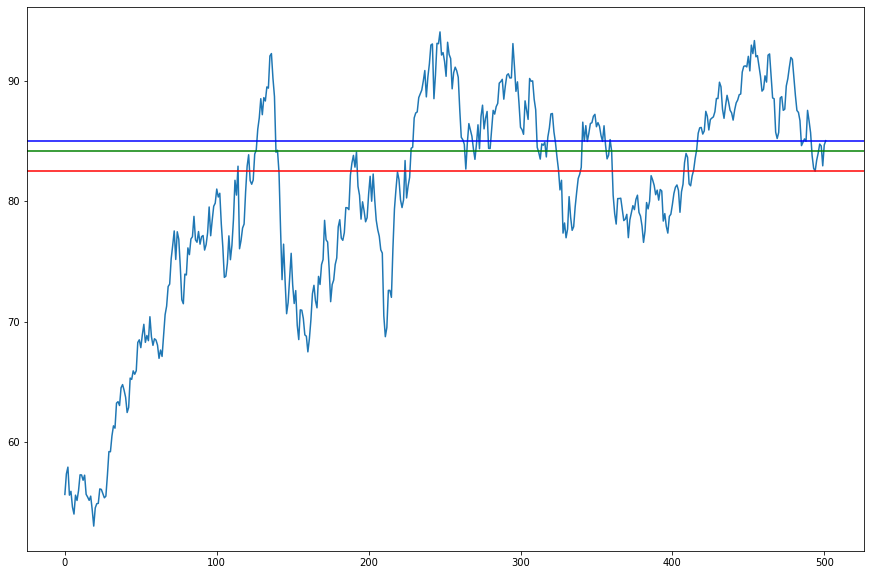

In [49]:
plot_entry_data(absolute_stock_data, abs_entries_lvl2.iloc[-1])

In [50]:
rel_entries_lvl2.iloc[-1]

type                   1.000000
stop_loss            189.251001
limit_entry          193.113266
limit_target_exit    195.044399
peak_id              597.000000
Name: 597, dtype: float64

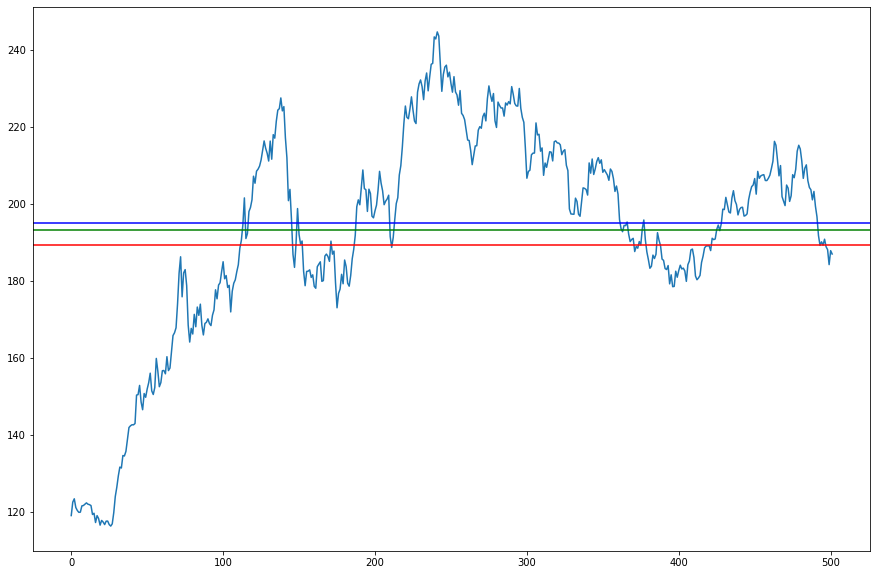

In [51]:
plot_entry_data(relative_stock_data, rel_entries_lvl2.iloc[-1])